<a href="https://colab.research.google.com/github/Zihooo/fine-tune-tutorial/blob/main/Tutorial_Codes_for_Fine_tune_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This colab is written in **Python** to illustrate the process of *fine-tuning*  state-of-the-art **Transformer** models to predict scores text

In [ ]:
# mount colab to Google Drive so that we can read data from Google Drive directly.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Fine-tuning proprietary model (GPT3.5)**

##Data preparation

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.1 MB/s eta 0:00:00


In [ ]:
train_file_path = '/content/drive/MyDrive/auto essay scoring/train_AES_t.csv'
eval_file_path = '/content/drive/MyDrive/auto essay scoring/val_AES_t.csv'
test_file_path = '/content/drive/MyDrive/auto essay scoring/test_AES_t.csv'

In [ ]:
# Read datasets
import pandas as pd

ds_train = pd.read_csv(train_file_path)
ds_eval = pd.read_csv(eval_file_path)
ds_test = pd.read_csv(test_file_path)

In [ ]:
# Because GPT models were trained on conversations, we need to reformat our original data into conversational format.
list_of_train = ds_train.values.tolist()
list_of_eval = ds_eval.values.tolist()

# 'system' gives the general instruction of this AI agent.This information only has to be provided once.
# 'user' is the textual input provided by the human.
# 'assistant' is GPT generated text.
ds_train_formatted = [
    {"messages": [
        {"role": "system", "content": "You are someone who assesses students' essays. The essay will be given to you as the question. Your assessment can be 'low', 'medium', or 'high'."},
        {'role': 'user', 'content': x[5]},
        {'role': 'assistant', 'content': x[4]}]} for x in list_of_train
]

In [ ]:
# same for the evaluation set
ds_valid_formatted = [
    {"messages": [
        {"role": "system", "content": "You are someone who assesses students' essays. The essay will be given to you as the question. Your assessment can be 'low', 'medium', or 'high'."},
        {'role': 'user', 'content': x[5]},
        {'role': 'assistant', 'content': x[4]}]} for x in list_of_eval
]

In [ ]:
# The test set doesn't have to be formatted at this phase.

In [ ]:
# Because GPT only accept json files for fine-tuning, we are transferring the original formatted files into json formats.
import json

with open('train.jsonl', 'w') as f:
    for line in ds_train_formatted:
        json.dump(line, f)
        f.write('\n')

with open('val.jsonl', 'w') as f:
    for line in ds_eval_formatted:
        json.dump(line, f)
        f.write('\n')

## Fine-tuning process

###Upload training files to OpenAI

In [ ]:
# import required pacakges and assign your OpenAi API here.
from pathlib import Path
from openai import OpenAI
import openai
import os

client = OpenAI(api_key= 'your api')

In [ ]:
# Upload training data to OpenAI
client.files.create(
  file=open("train.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-PAO5KCVUCYnzPpaGUD4qyCIq', bytes=13201, created_at=1711317521, filename='train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
# Copy paste the id from previous block and save it as your train data id.
train_id = 'file-PAO5KCVUCYnzPpaGUD4qyCIq'

In [ ]:
# Upload validation data
client.files.create(
  file=open("val.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-KBJOMPVsrjfDXgYzMKgH4IQT', bytes=4430, created_at=1711317529, filename='val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
# Copy paste the id from previous block and save it as your eval data id.
val_id = 'file-KBJOMPVsrjfDXgYzMKgH4IQT'

### Create fine-tuning task on OpenAI

In [ ]:
# Create a fine-tuned model
# In this example, we are fine-tuning GPT-3.5-turbo.
ft_task = client.fine_tuning.jobs.create(
  training_file=train_id,
  validation_file=val_id,
  model="gpt-3.5-turbo-0125" # other
)

In [ ]:
# Save your fine-tuning job id
job_id = response.id

FineTuningJob(id='ftjob-1IEarSYYDm4cPx4FQowC0oPz', created_at=1711317542, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='ft:gpt-3.5-turbo-0125:personal::96PotdV0', object='fine_tuning.job', organization_id='org-1JMKZI00Fkfv1TPsGHb3NTmp', result_files=[], status='validating_files', trained_tokens=None, training_file='file-PAO5KCVUCYnzPpaGUD4qyCIq', validation_file='file-KBJOMPVsrjfDXgYzMKgH4IQT', user_provided_suffix=None)

In [ ]:
# You can also copy paste the id from previous outputs.
job_id = 'ftjob-1IEarSYYDm4cPx4FQowC0oPz'

In [ ]:
# Retrieve the state of a fine-tune
# Once fine-tuning is over, you will receive an email and the 'status' in this output would be 'succeeded'
ft_task = client.fine_tuning.jobs.retrieve(job_id)
ft_task

FineTuningJob(id='ftjob-1IEarSYYDm4cPx4FQowC0oPz', created_at=1711317542, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::96QFDhfn', finished_at=1711317878, hyperparameters=Hyperparameters(n_epochs=5, batch_size=1, learning_rate_multiplier=2), model='ft:gpt-3.5-turbo-0125:personal::96PotdV0', object='fine_tuning.job', organization_id='org-1JMKZI00Fkfv1TPsGHb3NTmp', result_files=['file-FujMOSnUrtHi6DC18rgVR4ZB'], status='succeeded', trained_tokens=12055, training_file='file-PAO5KCVUCYnzPpaGUD4qyCIq', validation_file='file-KBJOMPVsrjfDXgYzMKgH4IQT', user_provided_suffix=None)

## Prediction

In [ ]:
# Here we iterate the fine-tuned model on each individual in your test set.
# Remember to use the fine-tuned model name, instead of the original model name (gpt-3.5-turbo) here.
# We do not have to provide the asisstant role here because it is what we want gpt to generate.
predict = []
for i in range(len(ds_test)):
  completion = client.chat.completions.create(
  model="ft:gpt-3.5-turbo-0613:personal::83xhI6ZZ",
  messages=[
    {'role': 'system', 'content': "You are someone who assesses students' essays. The essay will be given to you as the question."},
    {'role': 'user', 'content': f"Here is the essay:###{ds_test.Text[i]}###. Rate this essay, your assessment can only be 'low', 'medium', or 'high'. Do not provide your reason in the answer"}
  ]
  )
  predict.append(completion.choices[0].message.content)


In [ ]:
# Here are all predicted results
predict

['high',
 'high',
 'medium',
 'medium',
 'low',
 'high',
 'medium',
 'medium',
 'low',
 'medium',
 'medium',
 'medium',
 'medium',
 'high',
 'high',
 'low',
 'low',
 'high',
 'medium',
 'medium',
 'medium',
 'high',
 'medium',
 'medium',
 'high',
 'high',
 'medium',
 'medium',
 'high',
 'medium',
 'high',
 'high',
 'high',
 'medium',
 'medium',
 'medium',
 'medium',
 'low',
 'medium',
 'medium',
 'medium',
 'medium',
 'medium',
 'high',
 'medium',
 'high',
 'medium',
 'medium',
 'low',
 'medium',
 'medium',
 'medium',
 'medium',
 'high',
 'medium',
 'high',
 'medium',
 'high',
 'medium',
 'high',
 'high',
 'high',
 'high',
 'medium',
 'medium',
 'high',
 'high',
 'medium',
 'medium',
 'high',
 'medium',
 'high',
 'medium',
 'medium',
 'high',
 'high',
 'high',
 'medium',
 'medium',
 'low',
 'high',
 'medium',
 'medium',
 'medium',
 'medium',
 'medium',
 'medium',
 'high',
 'high',
 'high',
 'medium',
 'high',
 'medium',
 'medium',
 'medium',
 'high',
 'high',
 'high',
 'low',
 'medium'

In [ ]:
# Check the performance of your fine-tuned model
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay

labels = ['low', 'medium', 'high']
confusion = confusion_matrix(ds_test['Score Level'], predict,labels = labels)
accuracy = accuracy_score(ds_test['Score Level'], predict)
f1 = f1_score(ds_test['Score Level'], predict,average = 'weighted')
# Get accuracy and f1 measure
print(accuracy, f1)

0.8016528925619835 0.8028963178973851


In [ ]:
# Create a function to plot the confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds,normalize="true",labels = labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

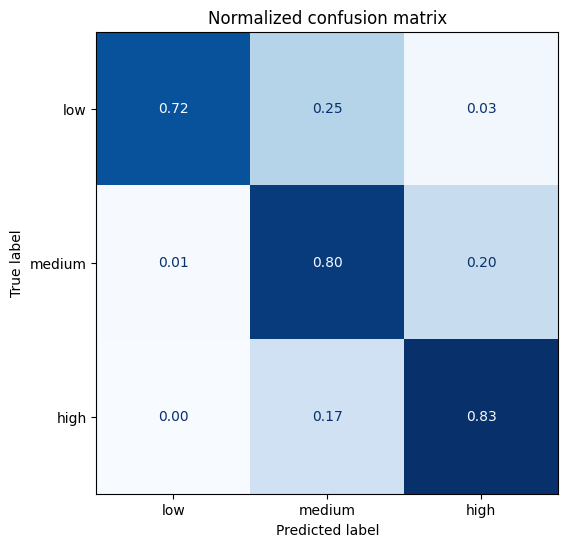

In [ ]:
# plot confusion matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(predict,ds_test['Score Level'],labels)

In [ ]:
# you can also compare it with original GPT-3.5-turbo
predict_original_model = []
for i in range(len(ds_test)):
  completion = client.chat.completions.create(
  model="gpt-3.5-turbo-0125",
  messages=[
    {'role': 'system', 'content': "You are someone who assesses students' essays. The essay will be given to you as the question."},
    {'role': 'user', 'content': f"Here is the essay:###{ds_test.Text[i]}###. Rate this essay, your assessment can only be 'low', 'medium', or 'high'. Do not provide your reason in the answer"}
  ]
  )
  predict_original_model.append(completion.choices[0].message.content)


In [ ]:
# First of all we can see that some of the responses are still not restricted in the range of "low" "medium" and "high"
predict_original_model

['Medium',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'High',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Low',
 'High',
 'Medium',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'Low',
 'Medium',
 'Medium',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Low',
 'High',
 'Medium',
 'Medium',
 'Medium',
 'Medium',
 'Low',
 'Medium',
 'Low',
 'Medium',
 'Medium',
 'High',
 'Low',
 'Low',
 'Low',
 'Medium',
 'Low',
 'Low',
 'Low',
 'Low',
 'High',
 'Low',
 'Med

In [ ]:
# Lowercase everything in the output
predict_original_model = [x.lower() for x in predict_original_model]

In [ ]:
# Now we replace those incorrect response formats into the correct format
for i in range(len(predict_original_model)):

    # replace hardik with shardul
    if predict_original_model[i] == "this essay is rated as 'low'.":
        predict_original_model[i] = 'low'

    # replace pant with ishan
    if predict_original_model[i] == 'rating: low':
        predict_original_model[i] = 'low'
    # replace pant with ishan
    if predict_original_model[i] == 'the assessment for this essay is low.':
        predict_original_model[i] = 'low'
    # replace pant with ishan
    if predict_original_model[i] == 'medium grade':
        predict_original_model[i] = 'medium'

In [ ]:
# the corrected output from GPT 3.5
predict_original_model

['medium',
 'medium',
 'medium',
 'low',
 'low',
 'low',
 'low',
 'low',
 'low',
 'low',
 'low',
 'low',
 'low',
 'medium',
 'high',
 'low',
 'low',
 'medium',
 'medium',
 'low',
 'low',
 'medium',
 'low',
 'low',
 'medium',
 'medium',
 'low',
 'low',
 'medium',
 'low',
 'high',
 'medium',
 'medium',
 'medium',
 'low',
 'low',
 'medium',
 'low',
 'medium',
 'low',
 'low',
 'low',
 'low',
 'medium',
 'medium',
 'low',
 'low',
 'medium',
 'low',
 'low',
 'low',
 'low',
 'low',
 'medium',
 'low',
 'low',
 'medium',
 'medium',
 'low',
 'medium',
 'medium',
 'medium',
 'medium',
 'low',
 'low',
 'low',
 'low',
 'medium',
 'medium',
 'medium',
 'medium',
 'low',
 'low',
 'low',
 'low',
 'medium',
 'medium',
 'medium',
 'low',
 'low',
 'medium',
 'low',
 'low',
 'low',
 'medium',
 'low',
 'low',
 'high',
 'medium',
 'medium',
 'medium',
 'medium',
 'low',
 'medium',
 'low',
 'medium',
 'medium',
 'high',
 'low',
 'low',
 'low',
 'medium',
 'low',
 'low',
 'low',
 'low',
 'high',
 'low',
 'med

In [ ]:
# Now get the performance of original GPT3.5 model.
labels = ['low', 'medium', 'high']
confusion = confusion_matrix(ds_test['Score Level'], predict_original_model,labels = labels)
accuracy = accuracy_score(ds_test['Score Level'], predict_original_model)
f1 = f1_score(ds_test['Score Level'], predict_original_model,average = 'weighted')
# Get accuracy and f1 measure, we can find it is much lower than the fine-tuned model.
print(accuracy, f1)

0.3581267217630854 0.35755536073364935


In [ ]:
# Save your outputs to a csv file in drive.
import csv

csv_file_path = '/content/drive/MyDrive/auto essay scoring/predicted_AES_t.csv'  # Replace with the desired CSV file path

with open(csv_file_path, 'w', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)

    # Write the header (optional)
    # csv_writer.writerow(['content'])

    # Write the extracted contents to the CSV file
    for content in predict:
        csv_writer.writerow([content])

# **Fine-tuning open-resource pre-trained LLM**

## Data preparation

In [ ]:
## install required pacakges
! pip install datasets
! pip install transformers
! pip install transformers[torch]
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 8.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-no

In [ ]:
# set the file path. Please note that you can also load the whole dataset first, then seperate it into train, validation and testing set in Python.
train_path = '/content/drive/MyDrive/tutorial of fine tune/dataset/train_data_extraversion.csv'
val_path = '/content/drive/MyDrive/tutorial of fine tune/dataset/eval_data_extraversion.csv'
test_path = '/content/drive/MyDrive/tutorial of fine tune/dataset/test_data_extraversion.csv'

In [ ]:
# load required fuctions from installed pacakges
from datasets import Dataset, DatasetDict
import pandas as pd
# Load train, validation, and test CSV files into DataFrames
# Here were are only reading the target columns which are 'response_E' and 'escore'
# 'response_E' is the participant's answer to the Extraversion question.
# 'escore' is the participant's Likert-type Extraversion score on a scale from 1 to 5.
train_df = pd.read_csv(train_path)[['response_E', 'escore']]
validation_df = pd.read_csv(val_path)[['response_E', 'escore']]
test_df = pd.read_csv(test_path)[['response_E', 'escore']]


# Convert DataFrames into Dataset objects
# We also rename the columns names so that the LLM can know which column is 'text' and which column is 'label'.
train_dataset = Dataset.from_pandas(train_df.rename(columns={'response_E': 'text', 'escore': 'labels'}))
validation_dataset = Dataset.from_pandas(validation_df.rename(columns={'response_E': 'text', 'escore': 'labels'}))
test_dataset = Dataset.from_pandas(test_df.rename(columns={'response_E': 'text','escore': 'labels'}))

# Create a DatasetDict with train, validation, and test splits
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

# Now you have a DatasetDict containing your datasets

## Fine-tuning Section

### Tokenization

In [ ]:
# We are using the DeBERTa-V3 model from Huggingface.
# More pre-trained LLM can be found on this website: https://huggingface.co/models.
# We should use the pre-trained tokenizer from our choosen pre-trained model.
from transformers import AutoTokenizer
model_ckpt = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Define a function to conduct tokenization
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
# Tokenize the whole data dictionary
dataset_encoded = dataset_dict.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/607 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

Map:   0%|          | 0/130 [00:00<?, ? examples/s]

In [ ]:
# Now we can see that besides the original columns, we also have 'input_ids', 'token_type_ids', 'attention_mask' in our tokenized data.
# These new columns will be fed into the LLM later as inputs.
dataset_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 607
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 130
    })
    test: Dataset({
        features: ['text', 'escore', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 130
    })
})

### Model Fine-tuning

In [ ]:
import torch
# Set the working device to GPT to increase computation efficiency. CPU would takes much longer time to fine-tune a LLM than GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Download the pre-trained LLM
from transformers import AutoModelForSequenceClassification

# We set number of labels equal to 1 to indicate a regression task.
# If the task is a multi-class classification task, please specify the exact number of classes here.
# We also save this model to our GPU.
num_labels = 1
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Here we create the evaluation metric. This block includes the evaluation metric for a classification task
#from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score

#def compute_metrics(pred):
#    labels = pred.label_ids
#    preds = pred.predictions.argmax(-1)
#    f1 = f1_score(labels, preds, average="weighted")
#    acc = accuracy_score(labels, preds)
#    recall = recall_score(labels, preds, average = "micro")
#    precision = precision_score(labels, preds, average = "micro")

#    return {"accuracy": acc, "f1": f1, "recall": recall, "precision": precision}

In [ ]:
# This block contains the evaluation metrics for regression task.
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    mse = mean_squared_error(labels, logits)
    r = pearsonr(labels.reshape(-1), logits.reshape(-1))
    rscore = r[0].tolist()
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    return {"mse": mse, "r": rscore}

In [ ]:
# Here we define the model parameters. These parameters will impact the model performance significantly
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(dataset_dict["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-tutorial"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5, # How many epochs for training.
                                  learning_rate=5e-5, # Usually start with a small number.
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.05, # Increase weight_decay can help avoid overfitting if sample size is small.
                                  evaluation_strategy="epoch",
                                  save_strategy = "epoch",  #checkpoint
                                  save_total_limit = 1,   #only save the best model
                                  logging_steps=logging_steps,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="mse", # the best model is determined based on this metric
                                  greater_is_better=False)  # related to the best metric we selected above

In [ ]:
# add previous settings to the trainer object and start training.
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics_for_regression, # ch
                  train_dataset=dataset_encoded['train'],
                  eval_dataset=dataset_encoded['validation'])
trainer.train();

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,R
1,1.434500,0.964471,0.964471,0.423401
2,0.783100,0.846831,0.846831,0.532544
3,0.516600,0.821004,0.821004,0.567543
4,0.264100,0.802280,0.802280,0.574743
5,0.175000,0.774779,0.774779,0.580700


In [ ]:
#torch.cuda.empty_cache()

##Prediction

In [ ]:
# First, we can check the model's performance on validation set again.
# Here we can double check which checkpoint has been saved after the training process.
preds_output = trainer.predict(dataset_encoded["validation"])
preds_output.metrics

{'test_loss': 0.7747794389724731,
 'test_mse': 0.7747794389724731,
 'test_r': 0.5806995773836291,
 'test_runtime': 0.8103,
 'test_samples_per_second': 160.443,
 'test_steps_per_second': 20.981}

In [ ]:
# Then, we can apply the fine-tuned model to our test set to get predicted scores.
test_output = trainer.predict(dataset_encoded["test"])
test_preds = test_output.predictions
# get predicted values
test_preds

array([3.0044403, 3.8701515, 2.186173 , 3.6523361, 1.7121878, 3.8408282,
       3.758883 , 2.1030855, 3.7095914, 3.7821665, 3.7284026, 4.014462 ,
       2.6644564, 2.8387508, 3.1074264, 3.918302 , 3.4463334, 3.406986 ,
       2.2558033, 3.0564752, 3.9535341, 2.600504 , 2.0312111, 3.5775409,
       3.682238 , 4.318311 , 3.5587926, 1.9895507, 1.9748157, 3.3118334,
       3.6782851, 1.7397373, 3.3229203, 2.6947968, 2.8853297, 2.2005808,
       3.6945739, 3.8353324, 3.2177205, 4.1336446, 3.329912 , 4.1266966,
       4.0849733, 3.437816 , 1.7395518, 3.0516195, 3.939684 , 3.0291   ,
       3.789688 , 4.0916896, 2.7424474, 3.1974902, 3.4594297, 3.520934 ,
       3.575313 , 2.5287685, 3.3391247, 2.0252912, 3.361448 , 2.90836  ,
       2.2457986, 2.8648899, 3.8544447, 3.780044 , 4.3746505, 1.7324191,
       3.0753384, 4.015461 , 4.0304046, 2.167046 , 2.9559333, 3.5367942,
       2.4212842, 3.482779 , 4.015461 , 3.2472584, 3.8065329, 2.3970547,
       3.7309027, 3.6129415, 2.6660135, 3.1059203, 

In [ ]:
# Now we can check the performance in our test set.
test_output.metrics

{'test_loss': 0.6811009049415588,
 'test_mse': 0.6811009049415588,
 'test_r': 0.5042455048886065,
 'test_runtime': 0.7255,
 'test_samples_per_second': 179.195,
 'test_steps_per_second': 23.433}